# General data reader for AQUA 
## Example of datasets on Lumi

We added a few new data sources to the intake catalogue, pointing to resources already available on LUMI.

### Inspecting available datasets

Multiple datasets area available also for observations, so that we can also inspect the catalogue by checking what is inside. This can be done with the `inspect_catalogue` function

In [1]:
from aqua import catalogue, inspect_catalogue
from aqua import Reader
cat = catalogue()

IFS	tco79-eORCA1	tco79-eORCA1 data
	- atm2d	
	- atm3d	
IFS	fdb-tco399	fdb-long data tco399 grid
	- fdb-long	FDB data tco399 grid
IFS	control-1950-devcon	FDB IFS/NEMO control run
	- hourly-native	hourly data on native grid TCo2560 (about 4.5km). Contains tprate(260048), 2t(167), 10u(165), 10v(166), 100u(228246), 100v(228247), sr(173), blh(159), sd(141), 2d(168), skt(235), chnk(148). See fix yaml for derived vars.
	- hourly-1deg	hourly data on r100 grid. Contains tprate(260048), sf(144), 2t(167), 10u(165), 10v(166), blh(159), sshf(146), slhf(147), ssrd(169), ssr(176), strd(175), str(177), ttr(179), e(182), tsr(178), ewss(180), nsss(181), chnk(148). See fix yaml for derived vars.
	- 6hourly-1deg	6hourly data on r100 grid. Contains z(129).
	- monthly-1deg-2d	monthly data on r100 grid. Contains tprate(260048), 2t(167), tcc(164), sd(141), tciw(79), tclw(78), msl(151), tcwv(137), lcc(186), mcc(187), hcc(188).
	- monthly-1deg-3d	monthly data on r100 grid. Contains u(131), v(132), t(130), r(157

Here below a short exploration at cataogue, model and experiment level

In [3]:
inspect_catalogue(cat)

Models available in catalogue:


['FESOM', 'IFS', 'ERA5', 'NEMO']

In [4]:
inspect_catalogue(cat, model = 'IFS')

Experiments available in catalogue for model IFS:


['test-tco79', 'tco79-eORCA1']

In [5]:
inspect_catalogue(cat, model = 'IFS', exp = 'tco79-eORCA1')

Sources available in catalogue for model IFS and exp tco79-eORCA1:


['atm2d', 'atm3d']

### IFS data

In [2]:
reader = Reader(model="IFS", exp="tco79-eORCA1", source="atm2d", regrid='r020')

In [3]:
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:  (time: 8305, value: 28480, level: 2)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(28480,), meta=np.ndarray>
  * level    (level) int64 0 1
    lon      (value) float64 dask.array<chunksize=(28480,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2020-12-31
Dimensions without coordinates: value
Data variables: (12/87)
    100si    (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    ...       ...
    vike     (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 28480), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

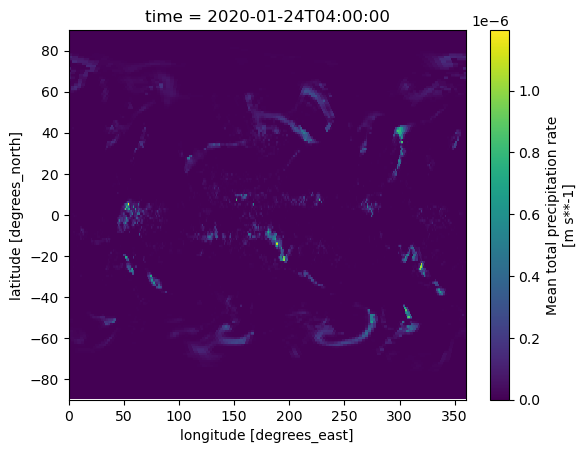

In [10]:
infile = data['tprate'].isel(time=100)
infile = reader.regrid(infile)
infile.plot()

In [12]:
reader = Reader(model="IFS", exp="tco79-eORCA1", source="atm3d", regrid='r100')

In [13]:
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:  (time: 1385, plev: 23, value: 28480)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(28480,), meta=np.ndarray>
  * plev     (plev) float64 1e+05 9.75e+04 9.5e+04 ... 3e+03 1e+03 100.0
    lon      (value) float64 dask.array<chunksize=(28480,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T06:00:00 ... 2020-12-31
Dimensions without coordinates: value
Data variables: (12/15)
    cc       (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    ciwc     (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    clwc     (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    crwc     (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    cswc     (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    d        (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    ...       ...
    u        (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    v        (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    vo       (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    w        (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    z        (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
    ~        (time, plev, value) float64 dask.array<chunksize=(1, 1, 28480), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

## NEMO access (experimental)

There is an experimantal source available at the moment on lumi:

In [16]:
reader = Reader(model='NEMO', exp='tco79-eORCA1', source='fdb_nomagician', areas=False)

2023-06-09 12:22:59 :: Reader :: WARNING  -> No fixes available for model NEMO


In [17]:
data = reader.retrieve(fix=False)

In [18]:
data

<xarray.Dataset>
Dimensions:      (time: 5927, cell: 120184, level: 75)
Coordinates:
  * level        (level) int64 1 2 3 4 5 6 7 8 9 ... 67 68 69 70 71 72 73 74 75
  * time         (time) datetime64[ns] 2020-01-20T02:00:00 ... 2020-09-23
Dimensions without coordinates: cell
Data variables: (12/18)
    avg_hc300m   (time, cell) float64 dask.array<chunksize=(1, 120184), meta=np.ndarray>
    avg_hc700m   (time, cell) float64 dask.array<chunksize=(1, 120184), meta=np.ndarray>
    avg_siconc   (time, cell) float64 dask.array<chunksize=(1, 120184), meta=np.ndarray>
    avg_sithick  (time, cell) float64 dask.array<chunksize=(1, 120184), meta=np.ndarray>
    avg_sos      (time, cell) float64 dask.array<chunksize=(1, 120184), meta=np.ndarray>
    avg_tos      (time, cell) float64 dask.array<chunksize=(1, 120184), meta=np.ndarray>
    ...           ...
    ulat         (cell) float64 dask.array<chunksize=(120184,), meta=np.ndarray>
    ulon         (cell) float64 dask.array<chunksize=(120184,), meta=np.ndarray>
    vlat         (cell) float64 dask.array<chunksize=(120184,), meta=np.ndarray>
    vlon         (cell) float64 dask.array<chunksize=(120184,), meta=np.ndarray>
    wlat         (cell) float64 dask.array<chunksize=(120184,), meta=np.ndarray>
    wlon         (cell) float64 dask.array<chunksize=(120184,), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          255
    uuidOfHGrid:        16076978-a048-4107-47dd-7c9876677b28
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.Ma...

`areas=True` still not working but data are available (notice in the plot below that value are not the one expected because NaN values are not what expected in the data description):

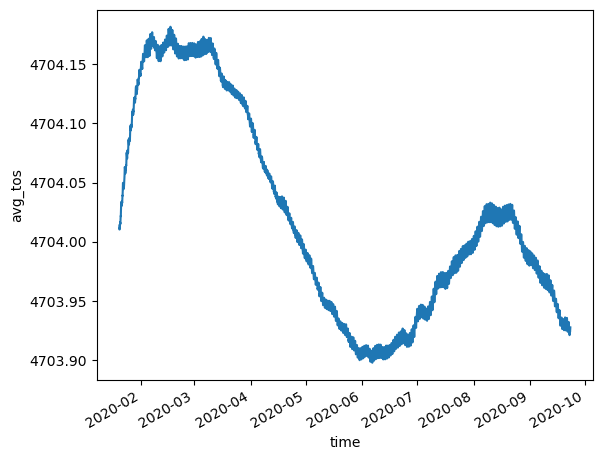

In [19]:
data.avg_tos.mean(dim='cell').plot()

## FDB/GSV access

We implemented FDB access in the reader using the GSV reader interface and a new intake driver which we developed. Also in this case the idea is to 'shield' the users from complex mars-style requests, allowing them to focus on the desired variables and experiments.

For the "fdb-test" dataset and a "fdb-long" datasets are available for basic testing, including some common climate variables, for a few days. as described in the [GSV Reader fdb-test documentation](https://earth.bsc.es/gitlab/digital-twins/de_340/gsv_interface/-/wikis/Specification-of-fdb-test) and [GSV Reader fdb-long documentation](https://earth.bsc.es/gitlab/digital-twins/de_340/gsv_interface/-/wikis/Specifications-of-fdb-long).

The default is now returning a standard dask-enabled xarray thanks to recent improvements to the interface which allow lazy dask access also for FDB/GSV data sources. It is still possible to obtain an iteratori instead, specifying the `streaming_generator=True` keyword.

Xarray/dask access (the default) is the recommended data access form, since it is the same used also for other data sources.

### Access to the fdb-test archive using dask

In [4]:
from aqua import Reader
reader = Reader(model="ERA5", exp="fdb", source="fdb-test")
data = reader.retrieve(var="tcc")

2023-09-09 17:54:16 :: Reader :: WARNING  -> No fixes available for model ERA5, experiment fdb


This produces a regular dask xarray Dataset:

In [5]:
data

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 720, time: 43393)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Data variables:
    tcc      (time, lat, lon) float64 dask.array<chunksize=(24, 720, 1440), meta=np.ndarray>
Attributes:
    history:  2023-09-09 17:54:23 dataset retrieved by GSV interface;\n2023-0...

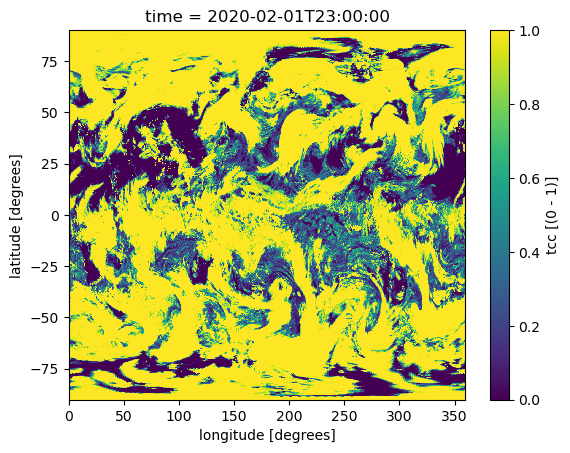

In [6]:
data.sel(time="20200201T2300").tcc.plot()

### Access to the fdb-test dataset using an iterator

It is also possible to get an iterator instead of a dask array using the keyword `streaming_generator=True`. For FDB sources this actually uses an iterator created dirextly by the GSV intake driver, instead of the streaming simulator. Notice the use, in this example, of the `aggregation` keyword, to specify aggregation/chunking, i.e. how much data to retriev at each iteration. This keyword, if specified, has actually also a meaning for dask access, specifying chunk size, but is better to just use the defaults read from the catalogue and not to specify it. The defaults take into account memory limitations in chunking. 

In [8]:
from aqua import Reader
reader = Reader(model="ERA5", exp="fdb", source="fdb-test", regrid="r200", aggregation="D")

2023-09-09 17:54:52 :: Reader :: WARNING  -> No fixes available for model ERA5, experiment fdb


In [9]:
data = reader.retrieve(startdate="20200125", enddate="20200129", var="tcc", streaming_generator=True)

The result is now an 'iterator'

In [10]:
data

<generator object FixerMixin._fixergen at 0x7f26720857e0>

We can either loop over the iterator or just get the next value. It is only now that the reader will actually retrieve the field(s) from FDB:

In [11]:
data0 = next(data)

In [12]:
data0

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 720, time: 24)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 2020-01-25 ... 2020-01-25T23:00:00
Data variables:
    tcc      (time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 0.9973 0.9973 0.9973
Attributes:
    history:  2023-09-09 17:55:06 dataset retrieved by GSV interface;\n2023-0...

This is the first day. Let's instead loop over the next ones:

In [13]:
for d in data:
    dm = reader.fldmean(d).mean(dim="time").tcc
    print(dm.values)

0.6779889981482511
0.6780318111850079
0.680480838944271
0.6832746275494994


The generator is now exhausted, let's get a fresh one

In [14]:
data = reader.retrieve(startdate="20200401", enddate="20200404", var="tcc", streaming_generator=True)

In [15]:
data

<generator object FixerMixin._fixergen at 0x7f28e93a4970>

The regridder can also operate on iterators:

In [16]:
datar = reader.regrid(data)
datar

<generator object Reader._regridgen at 0x7f28e93a4820>

In [17]:
next(datar)

<xarray.Dataset>
Dimensions:  (time: 24, lat: 90, lon: 180)
Coordinates:
  * time     (time) datetime64[ns] 2020-04-01 ... 2020-04-01T23:00:00
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    tcc      (time, lat, lon) float64 dask.array<chunksize=(24, 90, 180), meta=np.ndarray>
Attributes:
    history:  2023-09-09 17:56:11 dataset retrieved by GSV interface;\n2023-0...

### Access to the fdb-long archive

It is possible also to access the [fdb-long archive](https://earth.bsc.es/gitlab/digital-twins/de_340/gsv_interface/-/wikis/Specifications-of-fdb-long).
By default the GSV interface prints information to screen but we suppress this. It can be reactivated with the option `verbose=True`.

In [18]:
from aqua import Reader, catalogue
reader = Reader(model="IFS", exp="fdb-tco399", source="fdb-long", aggregation="D", regrid="r025", verbose="True")
data = reader.retrieve(startdate='20200120', enddate='20200413', var='ci')

Request:  0 ['ci'] 0 23 {'domain': 'g', 'class': 'rd', 'expver': 'hz9n', 'type': 'fc', 'stream': 'lwda', 'anoffset': 9, 'date': '20200120', 'time': '0000', 'param': ['ci'], 'levtype': 'sfc', 'step': '0/to/23'}
Correctly decoded ci     on level sfc    at 2020-01-20T00:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T01:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T02:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T03:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T04:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T05:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T06:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T07:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T08:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T09:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T10:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T11:00:00
Correctly decoded ci  

Request:  0 ['ci'] 0 23 {'domain': 'g', 'class': 'rd', 'expver': 'hz9n', 'type': 'fc', 'stream': 'lwda', 'anoffset': 9, 'date': '20200120', 'time': '0000', 'param': ['ci'], 'levtype': 'sfc', 'step': '0/to/23'}
Correctly decoded ci     on level sfc    at 2020-01-20T00:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T01:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T02:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T03:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T04:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T05:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T06:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T07:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T08:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T09:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T10:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T11:00:00
Correctly decoded ci  

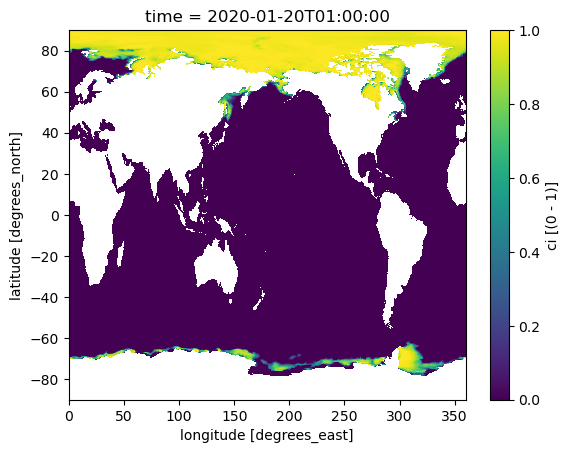

In [35]:
reader.regrid(data.ci.isel(time=1)).plot()

In [36]:
reader.fldmean(data.ci.isel(time=1)).values

Request:  0 ['ci'] 0 23 {'domain': 'g', 'class': 'rd', 'expver': 'hz9n', 'type': 'fc', 'stream': 'lwda', 'anoffset': 9, 'date': '20200120', 'time': '0000', 'param': ['ci'], 'levtype': 'sfc', 'step': '0/to/23'}
Correctly decoded ci     on level sfc    at 2020-01-20T00:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T01:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T02:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T03:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T04:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T05:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T06:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T07:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T08:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T09:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T10:00:00
Correctly decoded ci     on level sfc    at 2020-01-20T11:00:00
Correctly decoded ci  

array(0.0413731)

### FDB buffering

### (This feature is actually now outdated, since direct xarray dask access is possible, it will probably be removed)

In case you wish not to change your script to accomodate for an iterator, it is possible (paying the price of increased disk access and space) to buffer the result into a temporary directory. The user needs to specify the location of a directory in which such temporary directories will be created. The directories are temporary directories which should be erased automatically if the process is closed regularly. This is not always the case working in a notebook, so please do some houskeeping yourself.

In [38]:
from aqua import Reader, catalogue
reader = Reader(model="IFS", exp="fdb-tco399", source="fdb-long", aggregation="D", regrid="r025", buffer="/users/jvonhar/scratch/aqua_buffer", loglevel="INFO")
data = reader.retrieve(startdate='20200201', enddate='20200229', var='ci', streaming_generator=True)

2023-09-09 15:13:53 :: Reader :: INFO     -> Data model: ../../config/data_models/ifs2cds.json
2023-09-09 15:13:53 :: Reader :: INFO     -> Data model: ../../config/data_models/ifs2cds.json
2023-09-09 15:13:53 :: Reader :: INFO     -> Retrieving variables: ['ci']
2023-09-09 15:13:53 :: Reader :: INFO     -> Buffering iterator to: /users/jvonhar/scratch/aqua_buffer/tmpiv51xiig
2023-09-09 15:13:56 :: Reader :: INFO     -> Data model: ../../config/data_models/ifs2cds.json
2023-09-09 15:13:58 :: Reader :: INFO     -> Data model: ../../config/data_models/ifs2cds.json
2023-09-09 15:14:00 :: Reader :: INFO     -> Data model: ../../config/data_models/ifs2cds.json
2023-09-09 15:14:01 :: Reader :: INFO     -> Data model: ../../config/data_models/ifs2cds.json
2023-09-09 15:14:03 :: Reader :: INFO     -> Data model: ../../config/data_models/ifs2cds.json
2023-09-09 15:14:05 :: Reader :: INFO     -> Data model: ../../config/data_models/ifs2cds.json
2023-09-09 15:14:06 :: Reader :: INFO     -> Data m

The result is now a regular dask (lazy) xarray.Dataset

In [11]:
data

<xarray.Dataset>
Dimensions:     (ncells: 654400, cell_corners: 4, time: 696)
Coordinates:
    lon         (ncells) float64 dask.array<chunksize=(654400,), meta=np.ndarray>
    lat         (ncells) float64 dask.array<chunksize=(654400,), meta=np.ndarray>
    lon_bounds  (ncells, cell_corners) float64 dask.array<chunksize=(654400, 4), meta=np.ndarray>
    lat_bounds  (ncells, cell_corners) float64 dask.array<chunksize=(654400, 4), meta=np.ndarray>
  * time        (time) datetime64[ns] 2020-02-01 ... 2020-02-29T23:00:00
Dimensions without coordinates: ncells, cell_corners
Data variables:
    ci          (time, ncells) float64 dask.array<chunksize=(24, 654400), meta=np.ndarray>
Attributes:
    history:  2023-08-22 16:35:02 retrieved by AQUA retriever;\n2023-08-22 16...

It is now also possible to ask for buffering but not to specify a directory with `buffer=True` (instead of passing a string with the path). In this case the data from the iterator are collected directly in memory in an xarray.DataSet. This should be done only if the data actually fit (maybe because at the same time timemean and regrid operations have been asked for).
Notice how in this example we ask for `regrid=True` and `timmean=True` directly in the retrieve operation, so that these are done immediately **before** the buffering.

In [5]:
from aqua import Reader, catalogue
reader = Reader(model="IFS", exp="fdb-tco399", source="fdb-long", aggregation="D", regrid="r100", freq="daily", buffer=True)
data = reader.retrieve(startdate='20200201', enddate='20200229', var='2t', regrid=True, timmean=True, streaming_generator=True)

In [6]:
data

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 29)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 2020-02-01 2020-02-02 ... 2020-02-29
Data variables:
    2t       (time, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    history:  2023-08-29 02:28:27 dataset retrieved by GSV interface;\n2023-0...

### Access to the control and historical experiments

In [19]:
from aqua import Reader
reader = Reader(model='IFS', exp='control-1950-devcon', source='hourly-1deg')
data = reader.retrieve(var="2t")

The result is a dataset containing a dask DataArray for the full dataset:

In [20]:
data

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, time: 87648)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * time     (time) datetime64[ns] 1950-01-01 ... 1959-12-31T23:00:00
Data variables:
    2t       (time, lat, lon) float64 dask.array<chunksize=(24, 181, 360), meta=np.ndarray>
Attributes:
    history:  2023-09-09 17:58:16 dataset retrieved by GSV interface;\n2023-0...

We can now work on this as usual. For example this is the average over the month of January 1952:

In [23]:
data['2t'].sel(time=slice("19520101", "19520131T2300")).mean().values

array(276.59163528)

This took about 2m17s on LUMI. The data are represented by a dask xarray dataset, so if we use dask parallelism we can speed up things. Let us create a local cluster with 16 cores and two threads per core

In [1]:
from dask.distributed import LocalCluster, Client, progress
cluster = LocalCluster(ip="0.0.0.0", threads_per_worker=2, n_workers=16)
client = Client(cluster)
cluster

LocalCluster(7e3eae34, 'tcp://193.167.209.165:36859', workers=16, threads=32, memory=64.00 GiB)

Let's try again, this time with a cluster client

In [26]:
data['2t'].sel(time=slice("19520101", "19520131T2300")).mean().values

array(276.59163528)

Now it took only 23 seconds :)!

Finally, we read correctly also the monthly datasets (behind the scenes the date of these data is aligned so that it corresponds to the actual months):

In [40]:
from aqua import Reader
reader = Reader(model='IFS', exp='control-1950-devcon', source='monthly-1deg-2d')
data = reader.retrieve(var="hcc")

In [41]:
data

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, time: 120)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 1959-12-01
Data variables:
    hcc      (time, lat, lon) float64 dask.array<chunksize=(12, 181, 360), meta=np.ndarray>
Attributes:
    history:  2023-09-09 18:09:21 dataset retrieved by GSV interface;\n2023-0...

Final test: reading the historical simulation natively and converting it on the fly to a 2deg, daily averaged dataset:

In [12]:
from aqua import Reader
reader = Reader(model='IFS', exp='historical-1990-devcon', source='hourly-1deg', freq="daily", regrid="r200")
data = reader.retrieve(var="2t", regrid=True, timmean=True)

This is now an xarray of monthly means at low resolution. This took only a few seconds, since nothing has been computed yet (we are using dask)

In [13]:
data

<xarray.Dataset>
Dimensions:  (time: 365, lat: 90, lon: 180)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-12-31
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    2t       (time, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
Attributes:
    history:  2023-09-10 01:53:35 dataset retrieved by GSV interface;\n2023-0...

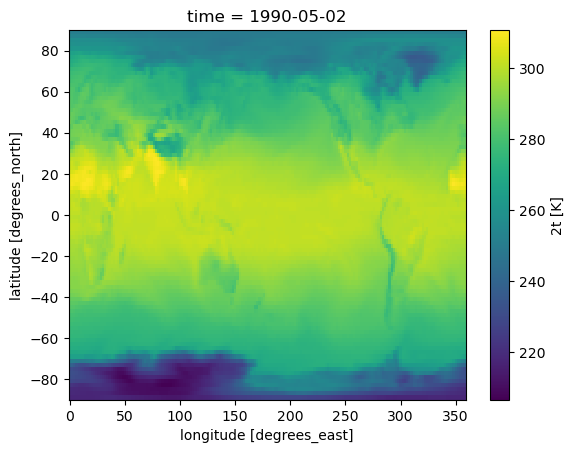

In [16]:
data['2t'].sel(time="19900502").plot()

### Access to new IFS-NEMO control and historical runs on LUMI

The new source have now been added to the catalogue and it is possible to read these data directly from the FDB through the reader

In [2]:
from aqua import Reader
reader = Reader(model='IFS', exp='control-1950-devcon', source='monthly-1deg-3d')
data = reader.retrieve(var="t")
next(data)


<xarray.Dataset>
Dimensions:  (lon: 360, lat: 181, time: 1, plev: 19)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * time     (time) datetime64[ns] 1950-01-01
  * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
Data variables:
    t        (time, plev, lat, lon) float64 246.8 246.8 246.8 ... 288.6 288.6
Attributes:
    history:  2023-08-29 13:43:55 dataset retrieved by GSV interface;\n2023-0...

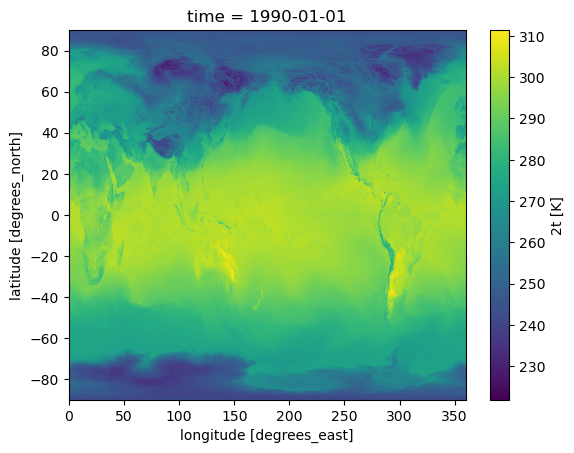

In [4]:
from aqua import Reader
reader = Reader(model='IFS', exp='historical-1990-devcon', source='hourly-native', aggregation="D", regrid="r025")
data = reader.retrieve(var="2t")
dd = next(data)
reader.regrid(dd)["2t"].isel(time=0).plot()